In [115]:
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from packaging import version 
import bioframe
from pybedtools import BedTool as pbt
import bbi
from tqdm import tqdm
from adjustText import adjust_text
import bioframe as bf
from os.path import basename
from typing import Dict, Any, Set, Optional
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
from typing import Dict, List
from numpy import inf

## gsea
import gseapy as gp
from gseapy import barplot, dotplot
import bioframe as bf


from dotenv import load_dotenv
assert os.environ['CONDA_DEFAULT_ENV'] == "cultures_hic"
load_dotenv()

True

In [77]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [17]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Helvetica'
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)

In [78]:
path_to_maps = os.getenv('PATH_TO_MAPS')
path_to_tads = os.getenv('PATH_TO_SAVE_TAD_BORDERS')
path_to_mapping = os.getenv('PATH_TO_MAIN_MAPS_MAPPING')
path_to_reduced_insulation_tables = os.getenv('PATH_TO_REDUCED_IS_TABLES')
path_to_save_pca_data = os.getenv('PATH_TO_SAVE_TAD_PCA_DATA')
path_to_tads_clusters = os.getenv('PATH_TO_TADS_CLUSTERS')
path_to_save_visualizations = os.getenv('PATH_TO_TADS_VISUALIZATIONS')
path_to_maps_expected = os.getenv('PATH_TO_EXPECTED_MAPS')
path_to_chromatin_annotation = os.getenv('PATH_TO_CHROMATIN_ANNOTATION')
path_to_cultural_h3k27me3 = os.getenv('PATH_TO_CULTURAL_H3K27ME3')
path_to_postmortal_h3k27me3 = os.getenv('PATH_TO_POSTMORTAL_H3K27ME3')
path_to_tfs = os.getenv('PATH_TO_TFS')
path_to_polycomb_dots = os.getenv('PATH_TO_POLYCOMB_DOTS')
path_to_up_genes_cultures_vs_postmortem = os.getenv('PATH_TO_UP_GENES_CULTURES_VS_POSTMORTEM')
path_to_down_genes_cultures_vs_postmortem = os.getenv('PATH_TO_DOWN_GENES_CULTURES_VS_POSTMORTEM')

In [99]:
palette = {
        'iPSC-derived neurons': '#469433',
        'Stem-like cells': 'dimgrey',
        'Fetal neurons': '#9c2725',
        'Post-mortem neurons': '#034e91',
        'Post-mortem non-neurons': '#764e3f',
        'iPSC-derived glia': '#ffa500',
        'Primary neurons': '#77658c'
    }

## 1. Intersect TAD borders with other features

In [135]:
def slope_bed(df, slope=0):
    """
    Extract unique bed regions from bedpe dataframe. Index is ignored.
    """
    df_bed = df[['chrom', 'start', 'end', 'cluster']].drop_duplicates()
    df_bed.start = df_bed.start-slope
    df_bed.end = df_bed.end+slope
    return df_bed 

In [136]:
selected_groups_name = "Post-mortem neurons_vs_iPSC-derived neurons"
tads_borders = pd.read_pickle(f'{path_to_tads_clusters}/{selected_groups_name}_clusters_merged_df.pickle')
tads_borders_slopped = slope_bed(tads_borders, slope=1500)
assert tads_borders_slopped.cluster.nunique() == tads_borders.cluster.nunique()

### 1.1 Gene 

In [137]:
### Gene annotation
chromatin_annotation = pd.read_pickle(f'{path_to_chromatin_annotation}/chromatin_annotation.feather')
promoters = chromatin_annotation[chromatin_annotation.type == "promoters"].reset_index(drop=True)
genes = chromatin_annotation[chromatin_annotation.type == "gene"].reset_index(drop=True)

genes_in_clusters = bf.overlap(genes, tads_borders_slopped, how='left', suffixes=('','_anno'))
genes_in_clusters = genes_in_clusters[['gene_name', 'gene_type','cluster_anno']].rename(columns = {'cluster_anno':'cluster'})
genes_in_clusters.drop_duplicates(inplace=True)
tads_borders = tads_borders.merge(genes_in_clusters, how='left', on = 'cluster')
tads_borders.rename(columns = {'gene_name':'gene_name_anno', 'gene_type':'gene_type_anno'}, inplace=True)
    

### 1.2 H3K27me3 

In [138]:
def get_overlap_with_h3k27me3(
    df1: pd.DataFrame, 
    h3k27me3_encode: pd.DataFrame, 
    column_new_name: str, 
    factor_slop: int = 0
) -> Dict[Any, bool]:
    """
    Calculate overlap with H3K27me3 and return a dictionary indicating overlap status.

    Parameters:
    - df1: pd.DataFrame - DataFrame containing genomic regions.
    - h3k27me3_encode: pd.DataFrame - DataFrame with H3K27me3 annotations.
    - column_new_name: str - Name for the new column indicating overlap.
    - factor_slop: int - Factor to adjust the start and end positions.

    Returns:
    - Dict[Any, bool] - Dictionary with cluster as keys and overlap status as values.
    """
    try:
        df1 = df1.drop_duplicates()
        df1['start'] = (df1['start'] - 15000 * factor_slop).astype(int)
        df1['end'] = (df1['end'] + 15000 * factor_slop).astype(int)
        df1_h3k27me3_encode = bf.overlap(df1, h3k27me3_encode, how='left', suffixes=('', '_anno'))
        
        df1_h3k27me3_encode[f'{column_new_name}_temp'] = df1_h3k27me3_encode['start_anno'].apply(
            lambda x: isinstance(x, int)
        )
        anchor_status_general = dict(
            df1_h3k27me3_encode[['cluster', f'{column_new_name}_temp']].drop_duplicates().values
        )
        unique_clusters = df1['cluster'].nunique()
        if len(anchor_status_general) != unique_clusters:
            logger.warning("Mismatch in unique cluster counts: expected %d, got %d", unique_clusters, len(anchor_status_general))

        return anchor_status_general

    except Exception as e:
        logger.error("An error occurred: %s", str(e))
        raise

In [139]:
### H3K27me3
### ENCODE h3k27me3 source for iPSC-derived

h3k27me3_encode = pd.read_csv(f'{path_to_cultural_h3k27me3}/ChIP-seq.H3K27me3.neurons.peaks.ENCFF104DEP.bed', sep = '\t', header = None)
h3k27me3_encode = h3k27me3_encode[h3k27me3_encode[8]>= 2]
h3k27me3_encode.columns = ['chrom', 'start', 'end',  'score', 'score1', 'score2', 'score3', 'score4', 'score5', 'score6']
h3k27me3_encode.shape

### Kozlenkov h3k27me3 source for post-mortem
h3k27me3_post_mortem = pd.read_csv(f'{path_to_postmortal_h3k27me3}/kozlenkov2018_merged_h3k27me3.bed',sep="\t" ,header=None)
h3k27me3_post_mortem.columns = ['chrom', 'start', 'end']
print(h3k27me3_encode.shape, h3k27me3_post_mortem.shape)

(15290, 10) (15594, 3)


In [140]:
{path_to_polycomb_dots}
# /pair_sites_polycomb_dot_anchors.csv

{'/tank/projects/diana_hic/tads/tads_results'}

In [142]:
merged_all_clusters_stats_h3k27me3_encode = get_overlap_with_h3k27me3(tads_borders, h3k27me3_encode, 'has_h3k27me3_peak_encode', factor_slop = 1.0)
tads_borders[ 'has_h3k27me3_peak_encode'] = tads_borders.cluster.map(merged_all_clusters_stats_h3k27me3_encode)

In [143]:
merged_all_clusters_stats_h3k27me3_kz = get_overlap_with_h3k27me3(tads_borders, h3k27me3_post_mortem, 'has_h3k27me3_peak_kozlenkov', factor_slop = 1.0)
tads_borders[ 'has_h3k27me3_peak_kozlenkov'] = tads_borders.cluster.map(merged_all_clusters_stats_h3k27me3_kz)

### 1.3 TFs

In [144]:
def intersection_with_human_tfs(merged_all_clusters: pd.DataFrame, tfs: Set[str]) -> pd.DataFrame:
    """
    Annotate clusters with the presence of transcription factors (TFs).

    Parameters:
    - merged_all_clusters: pd.DataFrame
        A DataFrame containing gene clusters with a 'cluster' and 'gene_name_anno' columns.
    - tfs: Set[str]
        A set of transcription factor names to check against the gene names in each cluster.

    Returns:
    - pd.DataFrame
        The input DataFrame with additional columns indicating the presence of TFs in each cluster.
    """
    required_columns = {'cluster', 'gene_name_anno'}
    if not required_columns.issubset(merged_all_clusters.columns):
        raise ValueError(f"Input DataFrame must contain the columns: {required_columns}")

    cluster_to_tfs = {}
    df_grouped = merged_all_clusters.groupby("cluster")

    for cluster, group in tqdm(df_grouped, desc="Processing clusters"):
        has_tf = bool(tfs.intersection(group['gene_name_anno']))
        cluster_to_tfs[cluster] = has_tf

    merged_all_clusters['tf_in_cluster'] = merged_all_clusters['cluster'].map(cluster_to_tfs)
    merged_all_clusters['tf_in_cluster_status'] = merged_all_clusters['tf_in_cluster'].apply(
        lambda x: "contains TF" if x else "no TFs"
    )

    return merged_all_clusters

In [145]:
tfs = pd.read_csv(f"{path_to_tfs}/DatabaseExtract_v_1.01.csv")
tfs = tfs[tfs['Is TF?']=="Yes"]
tfs = set(tfs['HGNC symbol'].tolist())
len(tfs)

1639

In [146]:
tads_borders = intersection_with_human_tfs(tads_borders, tfs)

Processing clusters: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 6796/6796 [00:00<00:00, 13973.08it/s]


### 1.4. Intersection with polycomb dots

In [147]:
def bedpe_to_bed(df: pd.DataFrame, ann_col: str = 'loop_num', slop: Optional[int] = None) -> pd.DataFrame:
    """
    Convert a BEDPE dataframe to a BED dataframe by extracting unique regions.
    
    Parameters:
    - df (pd.DataFrame): Input dataframe with BEDPE format containing columns 
                         ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', ann_col].
    - ann_col (str): The annotation column name to include in the BED output. Default is 'loop_num'.
    - slop (Optional[int]): Number of bases to extend the start and end positions. Default is None.
    
    Returns:
    - pd.DataFrame: A dataframe in BED format with columns ['chrom', 'start', 'end', ann_col, 'anchor'].
    
    Raises:
    - ValueError: If required columns are missing from the input dataframe.
    """
    required_columns = {'chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', ann_col}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Input dataframe must contain the following columns: {required_columns}")

    df_reg1 = df[['chrom1', 'start1', 'end1', ann_col]].copy()
    df_reg1['anchor'] = 'left_anh'
    df_reg2 = df[['chrom2', 'start2', 'end2', ann_col]].copy()
    df_reg2['anchor'] = 'right_anh'
    
    df_reg1.columns = df_reg1.columns.str.replace('1', '')
    df_reg2.columns = df_reg2.columns.str.replace('2', '')

    df_bed = pd.concat([df_reg1, df_reg2], ignore_index=True).drop_duplicates(ignore_index=True)

    if slop is not None:
        if not isinstance(slop, int) or slop < 0:
            raise ValueError("Slop must be a non-negative integer.")
        df_bed['start'] = (df_bed['start'] - slop).clip(lower=0).astype(int)
        df_bed['end'] = (df_bed['end'] + slop).astype(int)

    return df_bed

In [148]:
pair_sites =pd.read_csv(f"{path_to_polycomb_dots}/pair_sites_polycomb_dot_anchors.csv")
pair_sites['num'] = [i for i in range(pair_sites.shape[0])]
pair_sites_bed = bedpe_to_bed(pair_sites, ann_col ='num', slop=0)

polycombDots_in_clusters = bf.overlap(tads_borders, pair_sites_bed, how='left', suffixes=('','_polycombDots'))
    
groupped_pol = polycombDots_in_clusters[["cluster", 'chrom_polycombDots']].groupby("cluster")
updated = {}
for row in groupped_pol:
    all_status = row[1].chrom_polycombDots.tolist()
    if any(e != None for e in  all_status):
        updated[row[0]] = True
    else:
        updated[row[0]] = False
tads_borders[ 'has_polycombDot'] = tads_borders.cluster.map(updated)

### 1.5 Intersection with DEG

In [149]:
def intersection_with_deg(merged_all_clusters_stats_trueLoops, intersected_genes_down_set, 
                          intersected_genes_up_set, gene_column="gene_name_anno"):
    """
    Analyze the intersection of genes in clusters with upregulated and downregulated gene sets.

    Parameters:
    - merged_all_clusters_stats_trueLoops (pd.DataFrame): DataFrame containing cluster, gene details, and potentially more stats.
    - intersected_genes_down_set (set): Set of downregulated genes.
    - intersected_genes_up_set (set): Set of upregulated genes.
    - gene_column (str): Name of the column in `merged_all_clusters_stats_trueLoops` that contains gene names.

    Returns:
    - pd.DataFrame: Original DataFrame with an added column 'diff_genes_status' indicating the status of genes in each cluster.
    """

    if not isinstance(intersected_genes_down_set, set) or not isinstance(intersected_genes_up_set, set):
        raise TypeError("intersected_genes_down_set and intersected_genes_up_set must both be sets.")

    if gene_column not in merged_all_clusters_stats_trueLoops.columns:
        raise ValueError(f"'{gene_column}' is not a valid column in the input DataFrame.")

    status_genes = {}
    up_down_genes_for_cluster = {}
    
    # Remove duplicates based on gene and cluster columns
    deduplicated_df = merged_all_clusters_stats_trueLoops.drop_duplicates(subset=[gene_column, "cluster"])

    # Group by clusters and determine the status of genes within each cluster
    for cluster, df in deduplicated_df.groupby('cluster'):
        gene_set = set(df[gene_column])
        down_genes = gene_set & intersected_genes_down_set
        up_genes = gene_set & intersected_genes_up_set
        
        up_down_genes_for_cluster[cluster] = {
            "up": list(up_genes),
            "down": list(down_genes)
        }

        if up_genes and down_genes:
            status_genes[cluster] = "Up and Down genes"
        elif up_genes:
            status_genes[cluster] = "Up genes"
        elif down_genes:
            status_genes[cluster] = "Down genes"
        else:
            status_genes[cluster] = "No changed gene"

    merged_all_clusters_stats_trueLoops['diff_genes_status'] = merged_all_clusters_stats_trueLoops['cluster'].map(status_genes)

    return merged_all_clusters_stats_trueLoops

In [150]:
up_genes_cultures_vs_postmortem = pd.read_pickle(path_to_up_genes_cultures_vs_postmortem+ "genes_up_postmortem_vs_cultures.pickle")
down_genes_cultures_vs_postmortem = pd.read_pickle(path_to_down_genes_cultures_vs_postmortem+ "genes_dwn_postmortem_vs_cultures.pickle")
up_genes_cultures_vs_postmortem_set = set(up_genes_cultures_vs_postmortem[0].tolist())
down_genes_cultures_vs_postmortem_set = set(down_genes_cultures_vs_postmortem[0].tolist())

tads_borders = intersection_with_deg(tads_borders, down_genes_cultures_vs_postmortem_set, up_genes_cultures_vs_postmortem_set)

### 1.6 Intersection with gene promoters

In [151]:
def intersection_with_deg_promoters(
    merged_all_clusters_stats_trueLoops: pd.DataFrame, 
    intersected_genes_dwn_set: set, 
    intersected_genes_up_set: set, 
    gene_column: str = "gene_name_promoter"
) -> pd.DataFrame:
    """
    Analyzes the intersection of gene promoters with upregulated and downregulated genes
    within clusters and returns an updated DataFrame indicating the status of genes.
    
    Parameters:
    - merged_all_clusters_stats_trueLoops: A DataFrame with cluster statistics and gene information.
    - intersected_genes_dwn_set: A set of downregulated gene names.
    - intersected_genes_up_set: A set of upregulated gene names.
    - gene_column: The name of the column in DataFrame that contains gene names. Default is "gene_name_promoter".
    
    Returns:
    - Updated DataFrame with an additional column 'diff_genes_status_promoters' indicating gene status.
    """
    
    status_genes = {}
    up_down_genes_for_cluster = {}
    
    deduplicated_df = merged_all_clusters_stats_trueLoops[[gene_column, "cluster"]].drop_duplicates()
    
    for cluster, df in deduplicated_df.groupby('cluster'):
        gene_set = set(df[gene_column].dropna())  
        
        up_genes = gene_set & intersected_genes_up_set
        down_genes = gene_set & intersected_genes_dwn_set
        
        up_down_genes_for_cluster[cluster] = {
            "up": list(up_genes),
            "down": list(down_genes)
        }
        
        if up_genes and down_genes:
            status_genes[cluster] = "Up and Down genes"
        elif up_genes:
            status_genes[cluster] = "Up genes"
        elif down_genes:
            status_genes[cluster] = "Down genes"
        else:
            status_genes[cluster] = "no changed gene"
    
    merged_all_clusters_stats_trueLoops['diff_genes_status_promoters'] = merged_all_clusters_stats_trueLoops['cluster'].map(status_genes)
    
    return merged_all_clusters_stats_trueLoops


In [152]:
promoters_in_clusters = bf.overlap(promoters, tads_borders, how='left', suffixes=('','_promoters'))
promoters_in_clusters = promoters_in_clusters[['gene_name', 'gene_type','cluster_promoters']].rename(columns = {'gene_name':'gene_name_promoter','gene_type':'gene_type_promoter','cluster_promoters':'cluster'})
promoters_in_clusters.drop_duplicates(inplace=True)
tads_borders = tads_borders.merge(promoters_in_clusters, how='left', on = 'cluster')
tads_borders = intersection_with_deg_promoters(tads_borders, down_genes_cultures_vs_postmortem_set, up_genes_cultures_vs_postmortem_set)


# 2. Study up- and down- TAD borders

In [153]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [154]:
def perform_mann_whitney_test(data: pd.DataFrame, factors: Dict[str, int]) -> Dict:
    """
    Perform Mann-Whitney U test on clustered data.
    
    :param data: DataFrame containing the data
    :param factors: Dictionary containing 'factor_pm' and 'factor_ipsc'
    :return: Dictionary with statistical results for each cluster
    """
    mu_test_results = {}
    
    for cluster in data.cluster.unique():
        logging.debug(f"Processing cluster: {cluster}")

        cluster_data = data[data.cluster == cluster]
        data_ipsc = cluster_data[cluster_data.Group == 'iPSC-derived neurons'].boundary_strength_150000.tolist()
        data_pm = cluster_data[cluster_data.Group == 'Post-mortem neurons'].boundary_strength_150000.tolist()
        
        factor_pm = factors['factor_pm']
        factor_ipsc = factors['factor_ipsc']
        
        data_pm_new = ([0] * max(0, factor_pm - len(data_pm))) + data_pm
        data_ipsc_new = ([0] * max(0, factor_ipsc - len(data_ipsc))) + data_ipsc
        
        if len(data_pm_new) != factor_pm or len(data_ipsc_new) != factor_ipsc:
            raise ValueError(f"Data length mismatch for cluster {cluster}")
        
        mu_stat, p_value = mannwhitneyu(data_pm_new, data_ipsc_new, nan_policy='omit')
        mu_test_results[cluster] = {'mu_stat': mu_stat, 'p_value': p_value}
    
    return mu_test_results

def calculate_means(data: pd.DataFrame, factors: Dict[str, int]) -> (List[List[float]], List[List[float]]):
    """
    Calculate padded means for iPSC-derived and Post-mortem neurons.
    
    :param data: DataFrame containing the data
    :param factors: Dictionary containing 'factor_pm' and 'factor_ipsc'
    :return: Two lists containing means of iPSC-derived and Post-mortem neurons
    """
    tad_mean_ipsc = []
    tad_mean_pm = []

    for cluster in data.cluster.unique():
        logging.debug(f"Calculating means for cluster: {cluster}")

        cluster_data = data[data.cluster == cluster]
        data_ipsc = cluster_data[cluster_data.Group == 'iPSC-derived neurons'].boundary_strength_150000.tolist()
        data_pm = cluster_data[cluster_data.Group == 'Post-mortem neurons'].boundary_strength_150000.tolist()
        
        factor_pm = factors['factor_pm']
        factor_ipsc = factors['factor_ipsc']

        data_pm_new = ([0] * max(0, factor_pm - len(data_pm))) + data_pm
        data_ipsc_new = ([0] * max(0, factor_ipsc - len(data_ipsc))) + data_ipsc
        
        if len(data_pm_new) != factor_pm or len(data_ipsc_new) != factor_ipsc:
            raise ValueError(f"Data length mismatch for cluster {cluster}")

        tad_mean_ipsc.append(data_ipsc_new)
        tad_mean_pm.append(data_pm_new)
    
    return tad_mean_ipsc, tad_mean_pm

def create_plot_dataframe(tad_mean_ipsc: List[List[float]], tad_mean_pm: List[List[float]]) -> pd.DataFrame:
    """
    Create a DataFrame for plotting purposes.
    
    :param tad_mean_ipsc: Mean values for iPSC-derived neurons
    :param tad_mean_pm: Mean values for Post-mortem neurons
    :return: DataFrame ready for plotting
    """
    tad_ipsc_median = [np.nanmedian(i) for i in tad_mean_ipsc]
    tad_pm_median = [np.nanmedian(i) for i in tad_mean_pm]

    df_plot = pd.DataFrame()

    for sel_list, name in zip([tad_ipsc_median, tad_pm_median], ["iPSC-derived neurons", 'Post-mortem neurons']):
        df = pd.DataFrame(sel_list, columns=["border_strength"])
        df['source'] = name
        df_plot = pd.concat([df_plot, df], ignore_index=True)
    
    return df_plot

def plot_tad_border_strength(df_plot, TAD_MEAN_IPSC_MEAN, TAD_MEAN_PM_MEAN, save_path):
    """
    Plot a boxplot of TAD border strength and calculate Welch's t-test.

    Parameters:
    - df_plot (pd.DataFrame): DataFrame containing the data to plot. Should have columns 'source' and 'border_strength'.
    - TAD_MEAN_IPSC_MEAN (list or np.array): Data for TAD_MEAN_IPSC_MEAN for t-test.
    - TAD_MEAN_PM_MEAN (list or np.array): Data for TAD_MEAN_PM_MEAN for t-test.
    - save_path (str): Path where the plot will be saved.

    Returns:
    - None
    """

    plt.figure(figsize=(2, 3))    
    hue_order = ['Post-mortem neurons', 'iPSC-derived neurons']    
    ax = sns.boxplot(
        x='source', y='border_strength', data=df_plot, width=0.4,
        showmeans=True, boxprops=dict(linewidth=0.4),
        whiskerprops=dict(linewidth=0.4), capprops=dict(linewidth=0.4),
        medianprops=dict(linewidth=0.4), palette=palette,
        meanprops={"marker": "o", "markeredgecolor": "white", "markerfacecolor": "white", "markersize": "3"},
        showfliers=False
    )

    plt.legend(bbox_to_anchor=(1.3, 1.05), loc='upper right')
    plt.title('TAD Border Strength Boxplot')
    plt.xlabel('Source')
    plt.ylabel('Border Strength')

    plt.savefig(save_path, bbox_inches='tight', format='pdf')
    plt.show()

    t_stat, p_value = ttest_ind(TAD_MEAN_IPSC_MEAN, TAD_MEAN_PM_MEAN, equal_var=False)
    print(f"t-statistic: {t_stat}\np-value: {p_value}")

In [98]:
data_for_test = tads_borders[['chrom', 'start', 'end', 'boundary_strength_150000', 'cluster','Group', 'source']].drop_duplicates()
factors = {
    'factor_pm': round(tads_borders[["source", "Group"]].drop_duplicates().groupby('Group').size()['Post-mortem neurons']*1, 0), 
    'factor_ipsc': round(tads_borders[["source", "Group"]].drop_duplicates().groupby('Group').size()['iPSC-derived neurons']*1, 0)
}

mu_test_results = perform_mann_whitney_test(data_for_test, factors)

tad_mean_ipsc, tad_mean_pm = calculate_means(data_for_test, factors)
df_plot = create_plot_dataframe(tad_mean_ipsc, tad_mean_pm)
df_plot.head()

,border_strength,source
0,2.154506,iPSC-derived neurons
1,0.968744,iPSC-derived neurons
2,0.938826,iPSC-derived neurons
3,1.029404,iPSC-derived neurons
4,1.541195,iPSC-derived neurons


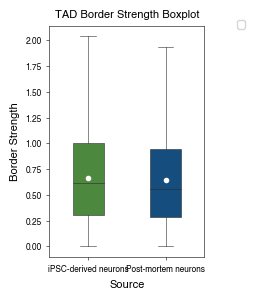

t-statistic: 1.9238272106515013
p-value: 0.05439717819259376


In [105]:
save_name = 'tads_border_strength_boxplot'
save_path = f"./tads_visualizations/{save_name}.pdf"
TAD_MEAN_IPSC_MEAN = [np.nanmedian(i) for i in tad_mean_ipsc]
TAD_MEAN_PM_MEAN = [np.nanmedian(i) for i in tad_mean_pm]
plot_tad_border_strength(df_plot, TAD_MEAN_IPSC_MEAN, TAD_MEAN_PM_MEAN, save_path)

# 3. Identification of differential TAD borders

## 3.1 Differential TAD borders

In [224]:
def process_mu_test_results(mu_test_results, tads_borders, p_value_cutoff=0.05):
    """
    Processes Mann-Whitney U test results and updates TADs borders with statistical status.

    Parameters:
    mu_test_results (dict): Dictionary containing Mann-Whitney U test results.
    tads_borders (pd.DataFrame): DataFrame containing TADs borders information.
    p_value_cutoff (float, optional): Significance level cutoff for p-values. Default is 0.05.

    Returns:
    pd.DataFrame: Updated DataFrame with statistical status annotations.
    """

    if not isinstance(mu_test_results, dict):
        raise ValueError("mu_test_results should be a dictionary.")
    if not isinstance(tads_borders, pd.DataFrame):
        raise ValueError("tads_borders should be a pandas DataFrame.")
    if not isinstance(p_value_cutoff, (float, int)) or not (0 < p_value_cutoff < 1):
        raise ValueError("p_value_cutoff should be a float between 0 and 1.")

    mu_test_df = pd.DataFrame(mu_test_results).T

    _, fdr_corrected = fdrcorrection(mu_test_df["p_value"])
    mu_test_df["q-value_mannwhitneyu-statistics"] = fdr_corrected
    mu_test_df.columns = ['mannwhitneyu_statistics', 'p-value_mannwhitneyu-statistics', 'q-value_mannwhitneyu-statistics']

    mu_test_df.reset_index(names=['cluster'], inplace=True)

    tads_borders = tads_borders.merge(mu_test_df, on='cluster', how='left')

    deduplicated_clusters = tads_borders[['mannwhitneyu_statistics']].drop_duplicates().mannwhitneyu_statistics.tolist()
    lower_quantile = np.median(deduplicated_clusters)
    upper_quantile = np.median(deduplicated_clusters)
    
    down_post_mortem = tads_borders.loc[
        (tads_borders['mannwhitneyu_statistics'] < lower_quantile) &
        (tads_borders['q-value_mannwhitneyu-statistics'] <= p_value_cutoff)
    ].cluster.tolist()

    up_post_mortem = tads_borders.loc[
        (tads_borders['mannwhitneyu_statistics'] > upper_quantile) &
        (tads_borders['q-value_mannwhitneyu-statistics'] <= p_value_cutoff)
    ].cluster.tolist()
    tads_borders['status_by_mu'] = tads_borders['cluster'].apply(
        lambda x: 'down_in_post_mortem' if x in down_post_mortem else
        ('up_in_post_mortem' if x in up_post_mortem else 'not_defined')
    )

    return tads_borders, up_post_mortem, down_post_mortem


In [225]:
tads_borders, up_post_mortem, down_post_mortem = process_mu_test_results(mu_test_results, tads_borders)
print(f'There are {len(set(down_post_mortem))} clusters that are down in Post-mortem')
print(f'There are {len(set(up_post_mortem))} clusters that are up in Post-mortem')

There are 452 clusters that are down in Post-mortem
There are 383 clusters that are up in Post-mortem


In [235]:
tads_borders[tads_borders.status_combined == 'down_in_post_mortem'][['gene_name_anno']].dropna().drop_duplicates().to_csv('./tads_borders_data/genes_in_down_in_post_mortem_tads_borders.csv', index=False)
tads_borders[tads_borders.status_combined == 'up_in_post_mortem'][['gene_name_anno']].dropna().drop_duplicates().to_csv('./tads_borders_data/genes_in_up_in_post_mortem_tads_borders.csv', index=False)
tads_borders[['gene_name_anno']].dropna().drop_duplicates().to_csv('./tads_borders_data/genes_in_all_presence_tads_borders.csv', index=False)


## 3.2 Missing TAD borders

In [229]:

    
def identify_differential_borders(tads_borders):
    factor_pm_reduced = round(tads_borders[["source", "Group"]].drop_duplicates().groupby('Group').size().get('Post-mortem neurons', 0) * 0.6)
    factor_ipcs_reduced = round(tads_borders[["source", "Group"]].drop_duplicates().groupby('Group').size().get('iPSC-derived neurons', 0) * 0.6)
    
    print(factor_ipcs_reduced, factor_pm_reduced)
    
    down_in_postmortem = []
    up_in_postmortem = []
    
    unique_clusters = tads_borders[["Group", 'source', 'cluster']].drop_duplicates()
    cluster_counts = unique_clusters.groupby(['cluster', 'Group']).size().reset_index(name='count')
    df_pivot = cluster_counts.pivot(index='cluster', columns='Group', values='count').fillna(0)
    
    df_pivot['iPSC-derived neurons'] = df_pivot.get('iPSC-derived neurons', 0)
    df_pivot['Post-mortem neurons'] = df_pivot.get('Post-mortem neurons', 0)
    
    for idx, row in tqdm(df_pivot.iterrows(), total=df_pivot.shape[0]):
        if row['Post-mortem neurons'] == 0 and row['iPSC-derived neurons'] >= factor_ipcs_reduced:
            down_in_postmortem.append(idx)
        elif row['iPSC-derived neurons'] == 0 and row['Post-mortem neurons'] >= factor_pm_reduced:
            up_in_postmortem.append(idx)
    
    print(len(down_in_postmortem), len(up_in_postmortem))
    def determine_status(cluster):
        if cluster in down_in_postmortem:
            return 'down_in_post_mortem'
        elif cluster in up_in_postmortem:
            return 'up_in_post_mortem'
        else:
            return 'not_defined'
    tads_borders['status_by_presence'] = tads_borders['cluster'].apply(determine_status)
    
    conditions = [
        (tads_borders['status_by_presence'] == "down_in_post_mortem") | (tads_borders['status_by_mu'] == "down_in_post_mortem"),
        (tads_borders['status_by_presence'] == "up_in_post_mortem") | (tads_borders['status_by_mu'] == "up_in_post_mortem")
    ]
    choices = ["down_in_post_mortem", "up_in_post_mortem"]
    tads_borders['status_combined'] = pd.Series(pd.np.select(conditions, choices, default="not_defined"))
    
    status_combined_list = tads_borders['status_combined'].tolist()
    tads_borders['status_combined'] = status_combined_list
    return tads_borders

In [230]:
tads_borders = identify_differential_borders(tads_borders)

4 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6796/6796 [00:00<00:00, 15224.18it/s]


555 294


/tmp/ipykernel_1868967/1585351521.py:38: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  tads_borders['status_combined'] = pd.Series(pd.np.select(conditions, choices, default="not_defined"))


In [231]:
tads_borders[['status_combined', 'cluster']].drop_duplicates().groupby('status_combined').size()

status_combined
down_in_post_mortem     905
not_defined            5305
up_in_post_mortem       586
dtype: int64

# 4. Intensity ratio

In [179]:
def process_tads_borders(tads_borders, save_path):
    grouped = tads_borders[['cluster', 'Group', 'boundary_strength_150000']].groupby(['cluster', 'Group']).median()
    
    log2FC_log2rloops = grouped.reset_index().sort_values(['cluster', 'Group'])    
    additional_data = []
    for cluster, group_data in log2FC_log2rloops.groupby('cluster'):
        present_groups = group_data['Group'].values
        for group in ['iPSC-derived neurons', "Post-mortem neurons"]:
            if group not in present_groups:
                additional_data.append({"cluster": cluster, "Group": group, "boundary_strength_150000": np.finfo(float).eps})
    

    additional_data_df = pd.DataFrame(additional_data)
    log2FC_log2rloops = pd.concat([log2FC_log2rloops, additional_data_df]).sort_values(['cluster', 'Group'])

    log2FC_log2rloops['ratio'] = log2FC_log2rloops.groupby('cluster')['boundary_strength_150000'].transform(
        lambda x: x.iloc[0] / (x.iloc[1] + np.finfo(float).eps)
    )
    log2FC_log2rloops['log2_ratio'] = np.log2(log2FC_log2rloops['ratio'])

    log2FC_log2rloops['status'] = log2FC_log2rloops.groupby('cluster')['boundary_strength_150000'].transform(
        lambda x: 'remove' if x.iloc[0] == 0 and x.iloc[1] == 0 else 'retain'
    )    

    df_filtered2 = log2FC_log2rloops[log2FC_log2rloops['status'] == 'retain'].copy()
    df_filtered2.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_filtered2.dropna(subset=["ratio", "log2_ratio"], how="any", inplace=True)

    ratios_df_log2ratio = np.array(df_filtered2['log2_ratio'].tolist())
    # ratios_df_log2ratio = np.clip(ratios_df_log2ratio, -3, 3)
    ratios_df_log2ratio[ratios_df_log2ratio == -inf] = 0
    ratios_df_log2ratio = [i for i in ratios_df_log2ratio if -3 <= i <= 3]



    plot_tads_borders(ratios_df_log2ratio, save_path)

def plot_tads_borders(ratios_df_log2ratio, save_path):
    plt.figure(figsize=(4, 2))  
    
    data_before_0 = [i for i in ratios_df_log2ratio if i < 0]
    data_after_0 = [i for i in ratios_df_log2ratio if i >= 0]

    color_before_0 = '#469433'  # Lighter shade of 'iPSC-derived neurons'
    color_after_0 = '#034e91'   # Lighter shade of 'Post-mortem neurons'

    plt.hist(data_before_0, bins=125, color=color_before_0, edgecolor=color_before_0, alpha=0.3, label='iPSC-derived neurons')
    plt.hist(data_after_0, bins=125, color=color_after_0, edgecolor=color_after_0, alpha=0.3, label='Post-mortem neurons')
    plt.axvline(x=0, color='blue', linestyle='--', linewidth=0.4)

    plt.xlabel('Log2 loop intensity ratio\n(Post-mortem neurons / iPSC-derived neurons)')
    plt.ylabel('Frequency')
    plt.xlim(-3, 3)
    plt.legend()
    plt.savefig(f"{save_path}", bbox_inches='tight', format = "pdf")

    plt.show()



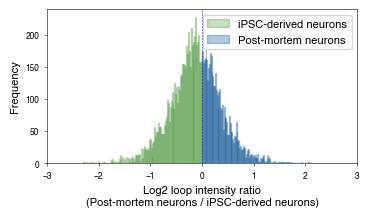

In [180]:
save_name = 'tads_border_histogram_ratio'
save_path = f"./tads_visualizations/{save_name}.pdf"
process_tads_borders(tads_borders, save_path)

# 5. Spread of TAD borders strengths

## 5.1 Spread of all TAD borders strengths

In [190]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def calculate_spread(data: pd.DataFrame, factors: Dict, save_path: str) -> pd.DataFrame:
    """
    Calculate the spread of boundary strengths for different neuron groups.

    Args:
        data (pd.DataFrame): DataFrame containing the neuron data with columns ['chrom', 'start', 'end',
                         'boundary_strength_150000', 'source', 'Group', 'cluster'].
        factor_pm (int): Padding factor for Post-mortem neurons.
        factor_ipsc (int): Padding factor for iPSC-derived neurons.

    Returns:
        pd.DataFrame: DataFrame containing the spread of boundary strengths for each cluster.
    """
    try:
        factor_pm = factors['factor_pm']
        factor_ipsc = factors['factor_ipsc']
        postmortem_spread, ipsc_spread = [], []

        data = data.drop_duplicates(subset=['chrom', 'start', 'end', 'boundary_strength_150000', 'source', 'Group', 'cluster'])

        for cluster in data['cluster'].unique():
            data_cluster = data[data['cluster'] == cluster]
            
            data_ipsc = data_cluster[data_cluster['Group'] == 'iPSC-derived neurons']['boundary_strength_150000'].tolist()
            data_pm = data_cluster[data_cluster['Group'] == 'Post-mortem neurons']['boundary_strength_150000'].tolist()
            
            data_pm_new = [0] * max(0, factor_pm - len(data_pm)) + data_pm
            data_ipsc_new = [0] * max(0, factor_ipsc - len(data_ipsc)) + data_ipsc
            
            if len(data_pm_new) != factor_pm or len(data_ipsc_new) != factor_ipsc:
                logging.warning(f"Cluster {cluster}: Length mismatch after padding.")
            
            postmortem_spread.append(np.std(data_pm_new))
            ipsc_spread.append(np.std(data_ipsc_new))

        spread_df = pd.DataFrame({
            'Post-mortem neurons': postmortem_spread,
            'iPSC-derived neurons': ipsc_spread,
            'cluster': data['cluster'].unique()
        }).reset_index()

        melted_df = spread_df.melt(
            id_vars=['index', 'cluster'],
            value_vars=['Post-mortem neurons', 'iPSC-derived neurons'],
            var_name='sample_type',
            value_name='spread'
        )

        logging.info("Spread calculation completed successfully.")
        plot_std(melted_df, save_path)

    except Exception as e:
        logging.error(f"An error occurred during spread calculation: {e}")
        raise

def plot_std(melted_df, save_path):
    plt.figure(figsize=(2, 3))
    order = ['Post-mortem neurons', 'iPSC-derived neurons'] 
    
    ax = sns.boxplot(x='sample_type', y='spread', width=0.4, data=melted_df,
                     showmeans=True,
                     hue = 'sample_type',
                     order = order,
                     boxprops=dict(linewidth=0.4),
                     whiskerprops=dict(linewidth=0.4),
                     capprops=dict(linewidth=0.4),
                     medianprops=dict(linewidth=0.4),
                     palette = palette,
                     meanprops={"marker": "o",
                                "markeredgecolor": "white",
                                "markerfacecolor": "white",
                                "markersize": "3"},
                     showfliers=False)
    plt.title('Spread of TAD Border Strength Values')
    plt.xlabel('Group')
    plt.ylabel('Spread (Standard Deviation)')
    plt.legend(bbox_to_anchor=(1.3, 1.05))
    plt.savefig(save_path, bbox_inches='tight', format = "pdf")
    plt.show()

INFO:root:Spread calculation completed successfully.


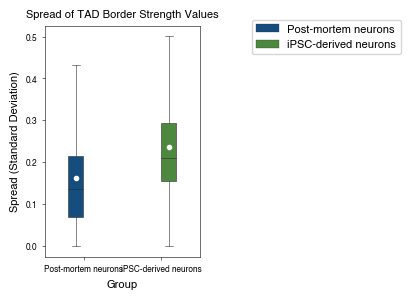

In [191]:
save_name = 'spread_of_tad_borders_strengthes'
save_path = f"./tads_visualizations/{save_name}.pdf"
calculate_spread(data_for_test, factors, save_path)

## 5.2 Spread of the selected TAD borders strengths

In [212]:
def generate_tad_borders_plot(tads_borders, factors, palette, save_dir='./tads_visualizations/', save_name='CSMD2_spread_tad_borders_strength'):
    """
    Generates and saves a plot of TAD border strengths for iPSC-derived and post-mortem neurons.
    
    :param tads_borders: DataFrame containing TAD border information.
    :param factors: Dictionary with factors for padding lists.
    :param palette: Color palette for plotting.
    :param save_dir: Directory to save the plot.
    :param save_name: Name of the file to save the plot.
    """
    
    try:
        postmortem_data = tads_borders[tads_borders['Group'] == 'Post-mortem neurons']
        ipsc_data = tads_borders[tads_borders['Group'] == 'iPSC-derived neurons']

        postmortem_spread = postmortem_data.groupby('cluster')['boundary_strength_150000'].std()
        ipsc_spread = ipsc_data.groupby('cluster')['boundary_strength_150000'].std()

        postmortem_data_CSMD2 = postmortem_data[postmortem_data.gene_name_promoter == "CSMD2"][['source', 'boundary_strength_150000']].drop_duplicates().boundary_strength_150000.tolist()
        ipsc_data_CSMD2 = ipsc_data[ipsc_data.gene_name_promoter == "CSMD2"][['source', 'boundary_strength_150000']].drop_duplicates().boundary_strength_150000.tolist()

      
        ipsc_data_CSMD2.extend([0] * (factors.get("factor_ipsc", 0) - len(ipsc_data_CSMD2)))
        postmortem_data_CSMD2.extend([0] * (factors.get("factor_pm", 0) - len(postmortem_data_CSMD2)))

        
        df_plot = pd.DataFrame()
        for sel_list, name in zip([ipsc_data_CSMD2, postmortem_data_CSMD2], ["iPSC-derived neurons", 'Post-mortem neurons']):
            df = pd.DataFrame(sel_list, columns=["border_strength"])
            df['source'] = name
            df_plot = pd.concat([df_plot, df])
        plt.figure(figsize=(2, 3))
        ax = sns.boxplot(data=df_plot, x="source", y="border_strength",
                         hue='source', whiskerprops=dict(linewidth=0.4),
                         capprops=dict(linewidth=0.4), medianprops=dict(linewidth=0.4),
                         palette=palette, width=0.3,
                         boxprops={'alpha': 0.4})
        sns.stripplot(data=df_plot, x="source", y="border_strength",
                      hue='source', palette=palette, dodge=True, ax=ax)
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(bbox_to_anchor=(1.3, 1.05))

        plt.savefig(f"{save_dir}{save_name}.pdf", bbox_inches='tight', format="pdf")
        plt.show()
        
    except Exception as e:
        print(f"An error occurred: {e}")


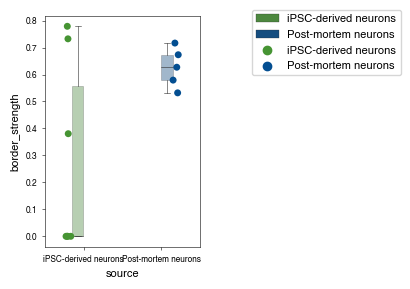

In [213]:
generate_tad_borders_plot(tads_borders, factors, palette)

# 6. Save resulted dataframe

In [233]:
save_name = "post_mortem_vs_iPSC_derived"
tads_borders.to_pickle(f"./tads_borders_data/{save_name}_tads_borders_properties.pickle")